In [8]:
import pandas as pd
import numpy as np
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  
password = getpass.getpass()

In [92]:
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

### IMPORTACIÓN BASE DE DATOS

In [27]:
archivo_csv = "C:\\Users\\roriv\\OneDrive\\Desktop\\BARKENO\\DF_FINAL_LIMPIO.csv"
df = pd.read_csv(archivo_csv)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130166 entries, 0 to 130165
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   pax_reserva        130166 non-null  int64 
 1   pax_reserva_menor  130166 non-null  int64 
 2   pax_real           130166 non-null  int64 
 3   dia_reserva        130166 non-null  object
 4   id_visita          130166 non-null  int64 
 5   dia_visita         130166 non-null  object
 6   hora_visita        130166 non-null  object
 7   id_idioma_visita   130166 non-null  int64 
 8   id_origen_reserva  130166 non-null  int64 
 9   realitzat          130166 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 9.9+ MB


### CLEANING-FUNCTION

In [34]:
def limpieza_barkeno(df):
    import pandas as pd
    import numpy as np

    
    digitos_validos = list(map(str, range(11)))
    df = df[df['pax_reserva'].astype(str).str.strip().isin(digitos_validos)]
 
    df['año_reserva'] = df['dia_reserva'].str.slice(0, 4)
    df['mes_reserva'] = df['dia_reserva'].str.slice(5, 7)
    df['dia_r'] = df['dia_reserva'].str.slice(8, 10)

    df['año_visita'] = df['dia_visita'].str.slice(0, 4)
    df['mes_visita'] = df['dia_visita'].str.slice(5, 7)
    df['dia_v'] = df['dia_visita'].str.slice(8, 10)

    df['dia_reserva'] = pd.to_datetime(df['dia_reserva'], format='%Y%m%d %H:%M:%S')
    df['dia_visita'] = pd.to_datetime(df['dia_visita'], format='%Y%m%d %H:%M:%S')

    # Transformación a formato fecha 

    df['dia_reserva'] = pd.to_datetime(df['dia_reserva'], format='%Y/%m/%d')
    df['dia_visita'] = pd.to_datetime(df['dia_visita'], format='%Y/%m/%d')

    # Dia de la semana y diferencia de dias.

    df['dia_reserva'] = pd.to_datetime(df['dia_reserva'])
    df['dia_visita'] = pd.to_datetime(df['dia_visita'])

    df['nombre_dia_reserva'] = df['dia_reserva'].dt.strftime('%A')
    df['nombre_dia_visita'] = df['dia_visita'].dt.strftime('%A')

    df['diferencia_dias'] = (df['dia_visita'] - df['dia_reserva']).dt.days

    # Categorización diferencias de dias. 
    bins = [0, 7, 14, 30, 60, 180, 365, float('inf')]
    labels = ['Menos de una semana', 'Una semana o más', 'Menos de un mes', '1-2 meses', '3-6 meses', '6-12 meses', 'Más de un año']
    df['categorias_dias'] = pd.cut(df['diferencia_dias'], bins=bins, labels=labels, right=False)


    mapeo_id_origen_reserva = {
    1: 'Barkeno Tours',
    2: 'GuruWalk',
    3: 'Yoorney',
    4: 'FreeTours',
    5: 'Civitatis',
    6: 'ReservaFreeTours',
    7: 'Be Local',
    8: 'Vipealo',
    9: 'Walkative',
    10: 'Buen Dia Tours',
    11: 'PuntoTours',
    12: 'By Foot',
    13: 'My Top Tour',
    14: 'Arkeo Tour',
    15: 'Atrápalo',
    16: 'Viabam'
}

    mapeo_id_idioma_visita = {
    1: 'Castellano',
    2: 'Inglés',
    3: 'Francés',
    4: 'Italiano'
}

    mapeo_id_visita = {
    1: 'Gótico',
    2: 'Modernismo',
    3: 'Raval',
    6: 'Born',
    7: 'Ciutadella',
    8: 'Maó',
    9: 'Tarragona'
}

    df['id_origen_reserva'] = df['id_origen_reserva'].replace(mapeo_id_origen_reserva)
    df['id_idioma_visita'] = df['id_idioma_visita'].replace(mapeo_id_idioma_visita)
    df['id_visita'] = df['id_visita'].replace(mapeo_id_visita)
    df['id_idioma_visita'] = df['id_idioma_visita'].replace(0, 'Castellano')
    df['id_visita'] = df['id_visita'].replace(0, 'Gótico')

    df['id_idioma_visita'] = df['id_idioma_visita'].replace(0, 'Castellano')
    df['hora_visita'] = df['hora_visita'].replace('10:04', '10:00')
    ocurrencias_hora = df['hora_visita'].value_counts()

    df['hora_visita'] = df['hora_visita'].replace('10:04', '10:00')
    ocurrencias_hora = df['hora_visita'].value_counts()

    valores_con_suficientes_ocurrencias = ocurrencias_hora[ocurrencias_hora >= 30].index

    df_filtrado = df[df['hora_visita'].isin(valores_con_suficientes_ocurrencias)]
    
    return df



In [37]:
data= limpieza_barkeno(df)

C:\Users\roriv\AppData\Local\Temp\ipykernel_10448\2124429745.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['año_reserva'] = df['dia_reserva'].str.slice(0, 4)
C:\Users\roriv\AppData\Local\Temp\ipykernel_10448\2124429745.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mes_reserva'] = df['dia_reserva'].str.slice(5, 7)
C:\Users\roriv\AppData\Local\Temp\ipykernel_10448\2124429745.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [38]:
data 

,pax_reserva,pax_reserva_menor,pax_real,dia_reserva,id_visita,dia_visita,hora_visita,id_idioma_visita,id_origen_reserva,realitzat,año_reserva,mes_reserva,dia_r,año_visita,mes_visita,dia_v,nombre_dia_reserva,nombre_dia_visita,diferencia_dias
0,1,0,1,2021-04-30,Gótico,2021-12-27,10:00:00,Castellano,Civitatis,0,2021,04,30,2021,12,27,Friday,Monday,241
1,1,0,1,2021-04-30,Modernismo,2021-12-30,16:00:00,Castellano,Civitatis,0,2021,04,30,2021,12,30,Friday,Thursday,244
2,2,0,2,2021-08-12,Gótico,2021-12-06,10:00:00,Castellano,Civitatis,1,2021,08,12,2021,12,06,Thursday,Monday,116
3,3,0,3,2021-09-16,Gótico,2021-12-30,10:00:00,Castellano,Civitatis,0,2021,09,16,2021,12,30,Thursday,Thursday,105
4,3,0,3,2021-09-15,Gótico,2021-12-30,10:00:00,Castellano,Civitatis,0,2021,09,15,2021,12,30,Wednesday,Thursday,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130161,6,0,6,2023-08-29,Modernismo,2023-08-31,16:00:00,Castellano,Civitatis,0,2023,08,29,2023,08,31,Tuesday,Thursday,2
130162,1,2,1,2023-08-29,Gótico,2023-08-30,16:30:00,Castellano,Civitatis,0,2023,08,29,2023,08,30,Tuesday,Wednesday,1
130163,2,0,2,2023-08-29,Gótico,2023-08-30,16:30:00,Castellano,Civitatis,0,2023,08,29,2023,08,30,Tuesday,Wednesday,1
130164,2,0,2,2023-08-29,Modernismo,2023-08-29,16:00:00,Inglés,FreeTours,0,2023,08,29,2023,08,29,Tuesday,Tuesday,0


In [40]:
nombre_archivo = 'data_barkeno_transformado.csv'

data.to_csv(nombre_archivo, index=False) 

### SQL-CONECTION
Creo una conexión con SQL para hacer un join con la tabla que tiene la información meterologica dea por dia. utilizo las fechas como punto de conexión.

In [9]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/barkeno_project'
engine = create_engine(connection_string)

In [42]:
data.to_sql(name="data_barkeno_transformado",con=engine, if_exists='replace', index=False)

130163

In [58]:
consulta_sql = """
SELECT b.*, M.prec, M.tmed, M.tmin, M.tmax, M.racha
FROM data_barkeno_transformado B
JOIN data_metereologico M
ON b.dia_visita = M.fecha;
"""

df_completo= pd.read_sql_query(consulta_sql, connection_string)

In [59]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59298 entries, 0 to 59297
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pax_reserva         59298 non-null  int64         
 1   pax_reserva_menor   59298 non-null  int64         
 2   pax_real            59298 non-null  int64         
 3   dia_reserva         59298 non-null  datetime64[ns]
 4   id_visita           59298 non-null  object        
 5   dia_visita          59298 non-null  datetime64[ns]
 6   hora_visita         59298 non-null  object        
 7   id_idioma_visita    59298 non-null  object        
 8   id_origen_reserva   59298 non-null  object        
 9   realitzat           59298 non-null  int64         
 10  año_reserva         59298 non-null  object        
 11  mes_reserva         59298 non-null  object        
 12  dia_r               59298 non-null  object        
 13  año_visita          59298 non-null  object    

### CLEANING METEOROLOGICO 

In [60]:
def clean_meteorological_data(df_completo):
    
    columns_to_modify = ['prec', 'tmed', 'tmin', 'tmax', 'racha']
    df_completo[columns_to_modify] = df_completo[columns_to_modify].apply(lambda col: col.str.replace(',', '.').astype(float))

    
    def classify_temperature(temperature):
        if temperature < 0:
            return "Muy Frío"
        elif 0 <= temperature <= 10:
            return "Frío"
        elif 10 < temperature <= 20:
            return "Templado"
        elif 20 < temperature <= 30:
            return "Cálido"
        else:
            return "Muy Cálido"

    def classify_precipitation(precipitation):
        if precipitation == 0:
            return "Sin Precipitación"
        elif 0.1 <= precipitation <= 5:
            return "Ligera Precipitación"
        elif 5.1 <= precipitation <= 20:
            return "Moderada Precipitación"
        elif 20.1 <= precipitation <= 40:
            return "Fuerte Precipitación"
        else:
            return "Muy Fuerte Precipitación"

    def classify_wind_speed(racha):
        if racha < 0.5:
            return "Viento Muy Bajo"
        elif 0.5 <= racha <= 2.0:
            return "Viento Bajo"
        elif 2.0 < racha <= 5.0:
            return "Viento Moderado"
        elif 5.0 < racha <= 9.7:
            return "Viento Fuerte"
        else:
            return "Viento Muy Fuerte"


    df_completo['categoria_temperatura'] = df_completo['tmed'].apply(classify_temperature)
    df_completo['categoria_precipitacion'] = df_completo['prec'].apply(classify_precipitation)
    df_completo['categoria_racha_viento'] = df_completo['racha'].apply(classify_wind_speed)
    df_completo = df_completo.drop(['dia_reserva', 'dia_visita'], axis=1)

    return df_completo


In [61]:
df_modelo=clean_meteorological_data(df_completo)

In [62]:
df_modelo

,pax_reserva,pax_reserva_menor,pax_real,id_visita,hora_visita,id_idioma_visita,id_origen_reserva,realitzat,año_reserva,mes_reserva,...,nombre_dia_visita,diferencia_dias,prec,tmed,tmin,tmax,racha,categoria_temperatura,categoria_precipitacion,categoria_racha_viento
0,1,0,1,Gótico,10:00:00,Castellano,Civitatis,0,2021,04,...,Monday,241,0.0,16.6,12.9,20.4,13.3,Templado,Sin Precipitación,Viento Muy Fuerte
1,1,0,1,Modernismo,16:00:00,Castellano,Civitatis,0,2021,04,...,Thursday,244,0.0,16.4,12.9,20.0,6.4,Templado,Sin Precipitación,Viento Fuerte
2,2,0,2,Gótico,10:00:00,Castellano,Civitatis,1,2021,08,...,Monday,116,0.0,10.4,6.2,14.7,8.6,Templado,Sin Precipitación,Viento Fuerte
3,3,0,3,Gótico,10:00:00,Castellano,Civitatis,0,2021,09,...,Thursday,105,0.0,16.4,12.9,20.0,6.4,Templado,Sin Precipitación,Viento Fuerte
4,3,0,3,Gótico,10:00:00,Castellano,Civitatis,0,2021,09,...,Thursday,106,0.0,16.4,12.9,20.0,6.4,Templado,Sin Precipitación,Viento Fuerte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,6,0,6,Modernismo,16:00:00,Castellano,Civitatis,0,2023,08,...,Thursday,2,0.0,23.5,20.5,26.5,8.6,Cálido,Sin Precipitación,Viento Fuerte
59294,1,2,1,Gótico,16:30:00,Castellano,Civitatis,0,2023,08,...,Wednesday,1,1.8,21.6,18.8,24.4,15.8,Cálido,Ligera Precipitación,Viento Muy Fuerte
59295,2,0,2,Gótico,16:30:00,Castellano,Civitatis,0,2023,08,...,Wednesday,1,1.8,21.6,18.8,24.4,15.8,Cálido,Ligera Precipitación,Viento Muy Fuerte
59296,2,0,2,Modernismo,16:00:00,Inglés,FreeTours,0,2023,08,...,Tuesday,0,40.2,21.6,17.2,26.1,23.3,Cálido,Muy Fuerte Precipitación,Viento Muy Fuerte


### **EDA**

C:\Users\roriv\AppData\Local\Temp\ipykernel_10448\831394029.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_modelo.corr()


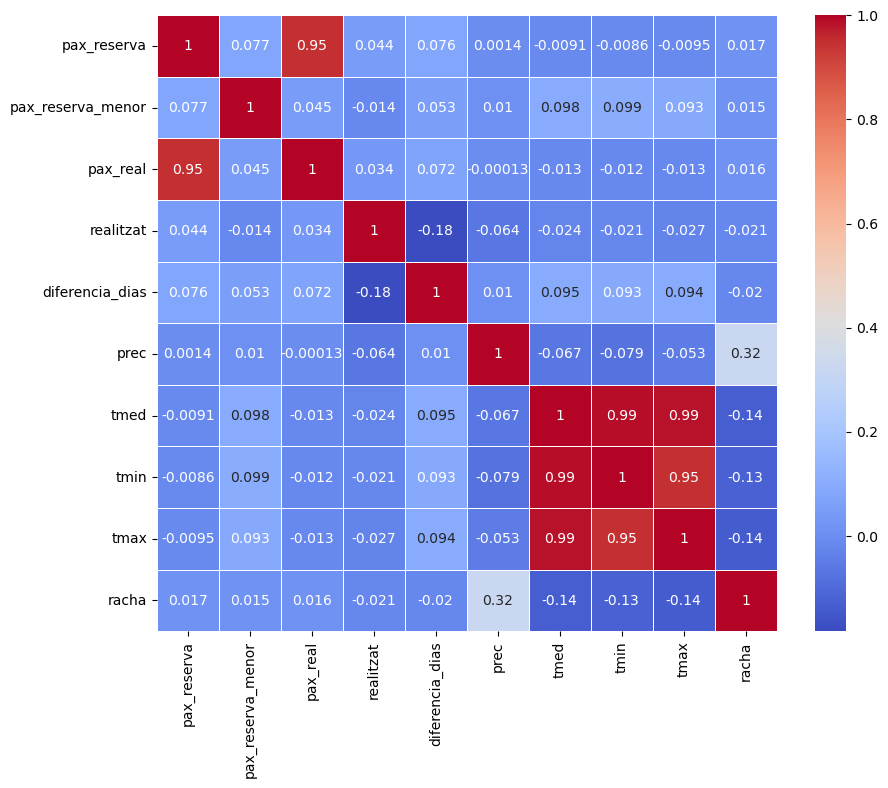

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_modelo.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.show()

Con los resultados de esta matriz, podemos observar la correlación entre variables, 

In [65]:
# tratamiento de correlación 
df_modelo['n_no_asistentes'] = df_modelo['pax_reserva'] - df_modelo['pax_real']
df_modelo.drop(columns=['tmin', 'tmax', 'pax_reserva'], inplace=True)

C:\Users\roriv\AppData\Local\Temp\ipykernel_10448\1226922172.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_modelo.corr()


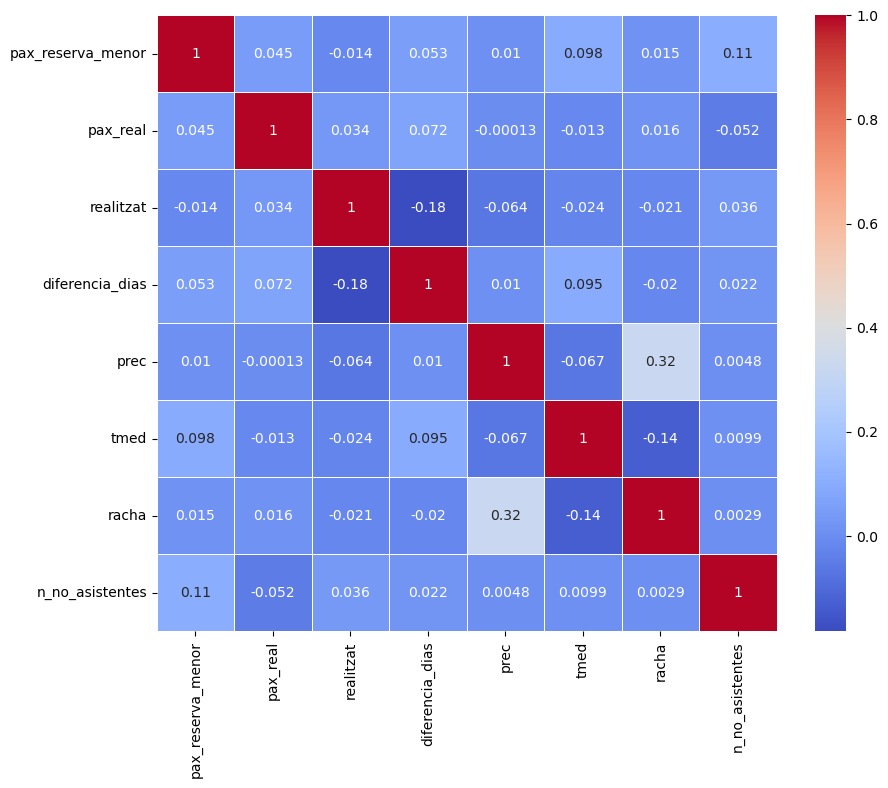

In [66]:
correlation_matrix = df_modelo.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.show()

### DISTRIBUTION

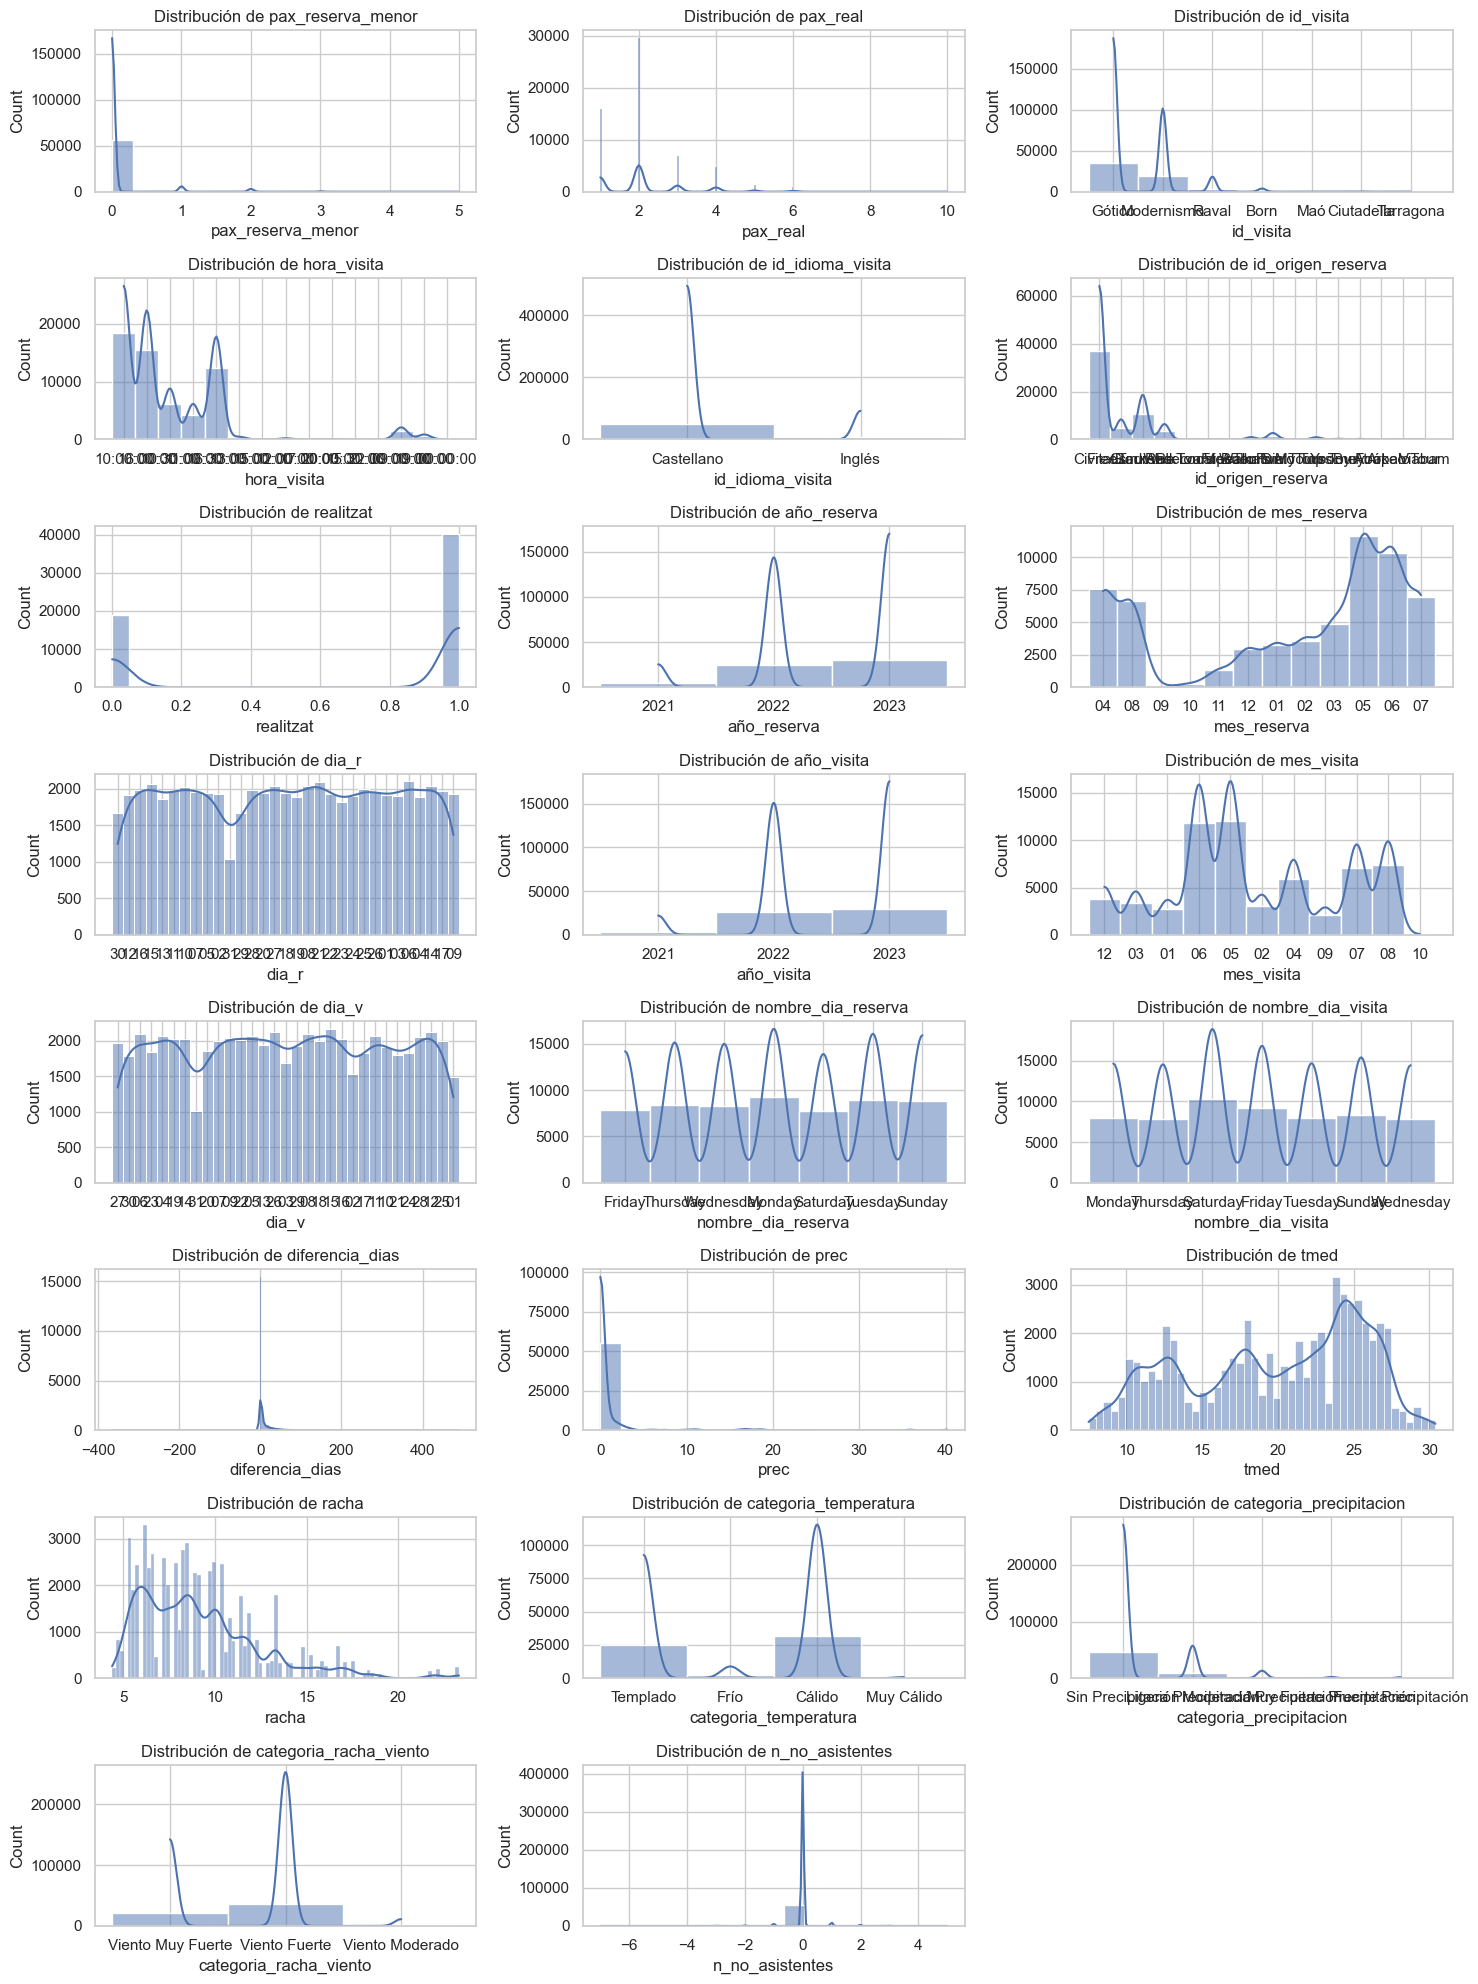

In [67]:
sns.set(style="whitegrid")

num_cols = 3
num_rows = (len(df_modelo.columns) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

for i, col in enumerate(df_modelo.columns):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(df_modelo[col], kde=True, ax=ax)
    ax.set_title(f'Distribución de {col}')

for i in range(len(df_modelo.columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

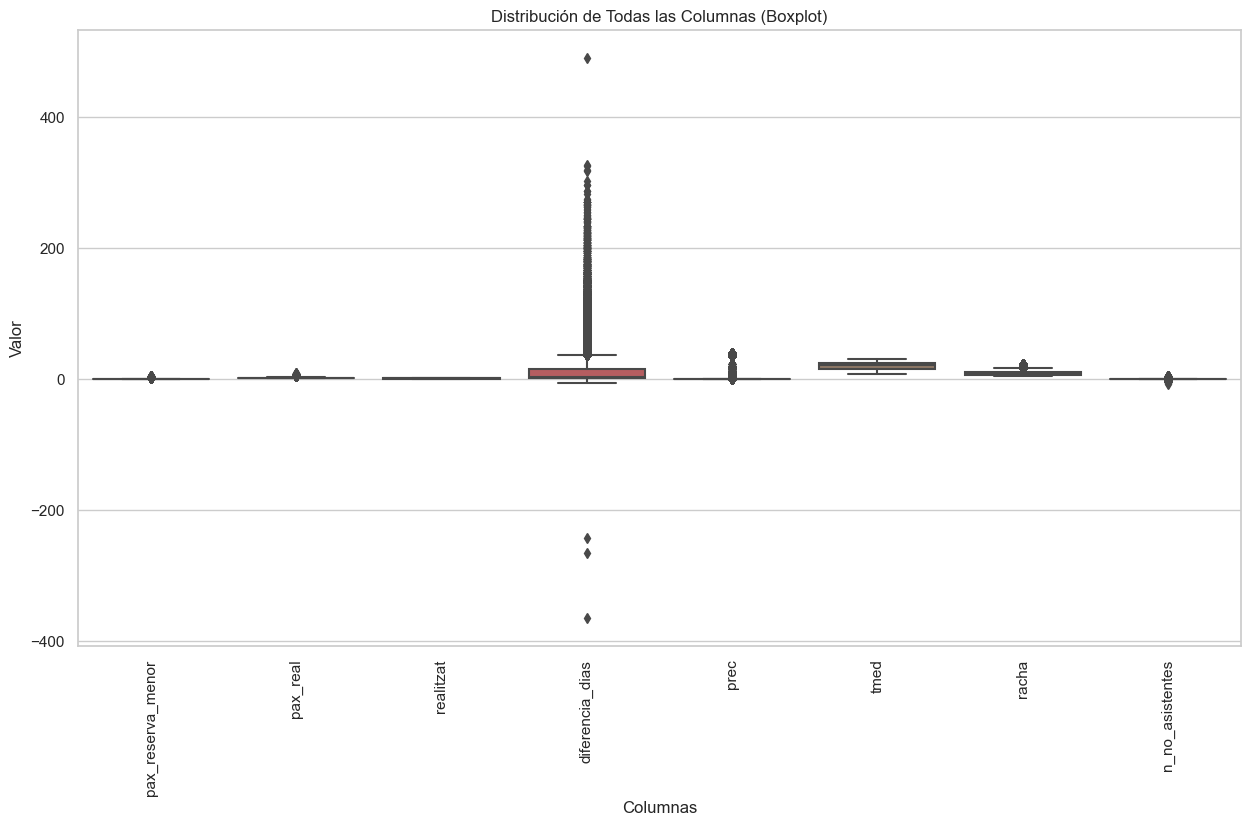

In [68]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_modelo, orient="v")
plt.xlabel("Columnas")
plt.ylabel("Valor")
plt.title("Distribución de Todas las Columnas (Boxplot)")
plt.xticks(rotation=90)
plt.show()

La distribución de datos me indica que en una de las columnas (diferencia_dias), tiene mucha presencia de outliers, el tratamiento será una eliminación a partir de los rangos intercuartilicos. Además eliminaré los valores negativos para luego aplicarle una transformación logaritmica. 

In [69]:
df_modelo.diferencia_dias.value_counts()

 1      15432
 0       8439
 2       5350
 3       2883
 4       2123
        ...  
-365        1
 296        1
 318        1
-6          1
 241        1
Name: diferencia_dias, Length: 271, dtype: int64

In [72]:
# Limpieza de outliers por rango intercuartilico 
Q1 = df_modelo['diferencia_dias'].quantile(0.25)
Q3 = df_modelo['diferencia_dias'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_modelo_cleaned = df_modelo[(df_modelo['diferencia_dias'] >= lower_limit) & (df_modelo['diferencia_dias'] <= upper_limit)]

In [77]:
df_modelo_cleaned.diferencia_dias.value_counts()

1     15432
0      8439
2      5350
3      2883
4      2123
5      1684
6      1446
7      1188
8      1049
9       954
10      812
11      731
12      689
13      648
14      626
15      549
17      543
16      539
20      519
18      515
19      475
21      470
23      426
22      406
27      367
24      359
26      342
30      341
25      329
31      316
28      285
32      278
29      270
34      270
33      257
35      246
36      226
Name: diferencia_dias, dtype: int64

In [76]:
#Me quedo solo con valores positivos para poder aplicar la transformación logaritmica. 
df_modelo_cleaned = df_modelo_cleaned[df_modelo_cleaned['diferencia_dias'] >= 0]

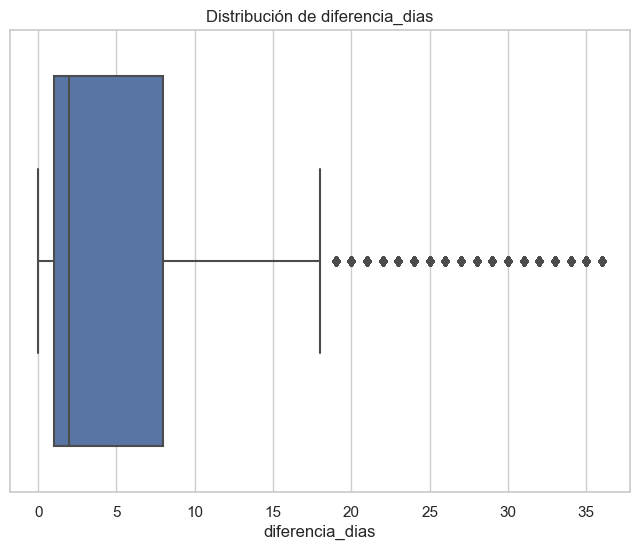

In [79]:
# Grafica outliers
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_modelo_cleaned['diferencia_dias'])
plt.title("Distribución de diferencia_dias")
plt.show()

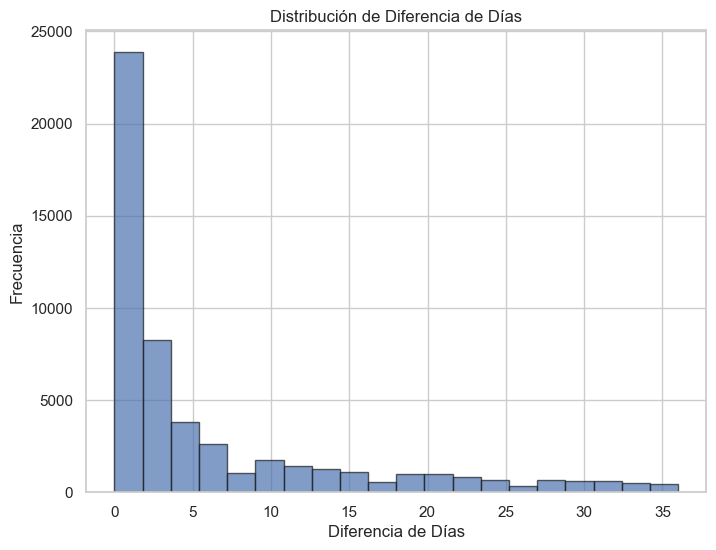

In [80]:
# grafica distribución
plt.figure(figsize=(8, 6))
plt.hist(df_modelo_cleaned['diferencia_dias'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Diferencia de Días')
plt.ylabel('Frecuencia')
plt.title('Distribución de Diferencia de Días')
plt.show()

In [82]:
df_copy = df_modelo_cleaned.copy()
df_copy['diferencia_dias'] = np.log1p(df_copy['diferencia_dias'])

In [112]:
#Descargo DF procesado.

nombre_archivo2 = 'DF_procesado_premodelo.csv'

df_copy.to_csv(nombre_archivo2, index=False) 

In [134]:
df_copy

,pax_reserva_menor,pax_real,id_visita,hora_visita,id_idioma_visita,id_origen_reserva,realitzat,año_reserva,mes_reserva,dia_r,...,nombre_dia_reserva,nombre_dia_visita,diferencia_dias,prec,tmed,racha,categoria_temperatura,categoria_precipitacion,categoria_racha_viento,n_no_asistentes
50,0,2,Modernismo,16:00:00,Castellano,GuruWalk,1,2021,10,31,...,Sunday,Sunday,1.522467,0.0,9.8,17.5,Frío,Sin Precipitación,Viento Muy Fuerte,0
51,0,5,Modernismo,16:00:00,Castellano,GuruWalk,1,2021,10,31,...,Sunday,Monday,1.528427,0.0,10.4,8.6,Templado,Sin Precipitación,Viento Fuerte,0
52,0,2,Gótico,10:00:00,Castellano,FreeTours,1,2021,11,03,...,Wednesday,Saturday,1.496434,0.0,13.2,13.3,Templado,Sin Precipitación,Viento Muy Fuerte,0
53,0,2,Modernismo,16:00:00,Castellano,FreeTours,0,2021,11,03,...,Wednesday,Wednesday,1.522467,0.0,10.8,21.7,Templado,Sin Precipitación,Viento Muy Fuerte,0
55,0,2,Modernismo,16:00:00,Castellano,GuruWalk,0,2021,11,06,...,Saturday,Tuesday,1.496434,0.0,11.2,8.3,Templado,Sin Precipitación,Viento Fuerte,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,0,6,Modernismo,16:00:00,Castellano,Civitatis,0,2023,08,29,...,Tuesday,Thursday,0.741276,0.0,23.5,8.6,Cálido,Sin Precipitación,Viento Fuerte,0
59294,2,1,Gótico,16:30:00,Castellano,Civitatis,0,2023,08,29,...,Tuesday,Wednesday,0.526589,1.8,21.6,15.8,Cálido,Ligera Precipitación,Viento Muy Fuerte,0
59295,0,2,Gótico,16:30:00,Castellano,Civitatis,0,2023,08,29,...,Tuesday,Wednesday,0.526589,1.8,21.6,15.8,Cálido,Ligera Precipitación,Viento Muy Fuerte,0
59296,0,2,Modernismo,16:00:00,Inglés,FreeTours,0,2023,08,29,...,Tuesday,Tuesday,0.000000,40.2,21.6,23.3,Cálido,Muy Fuerte Precipitación,Viento Muy Fuerte,0


### PREPARACIÓN-MODELO

In [86]:
# separo variables- numericas/categoricas
df_num = df_copy.select_dtypes(include=['number'])
df_cat = df_copy.select_dtypes(exclude=['number'])

In [89]:
# Dummies para categoricas.

df_cat_codificado = pd.get_dummies(df_cat, columns=df_cat.columns)
df_cat_codificado

,id_visita_Born,id_visita_Ciutadella,id_visita_Gótico,id_visita_Maó,id_visita_Modernismo,id_visita_Raval,id_visita_Tarragona,hora_visita_00:00:00,hora_visita_09:00:00,hora_visita_10:00:00,...,categoria_temperatura_Muy Cálido,categoria_temperatura_Templado,categoria_precipitacion_Fuerte Precipitación,categoria_precipitacion_Ligera Precipitación,categoria_precipitacion_Moderada Precipitación,categoria_precipitacion_Muy Fuerte Precipitación,categoria_precipitacion_Sin Precipitación,categoria_racha_viento_Viento Fuerte,categoria_racha_viento_Viento Moderado,categoria_racha_viento_Viento Muy Fuerte
50,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
51,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
52,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
53,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
55,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
59294,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
59295,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
59296,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [90]:
# uno dataframes categorico con dummies y el numerico. 
df_sin_normalizar= pd.concat([df_cat_codificado, df_num], axis=1)

In [104]:
df_sin_faltantes = df_sin_normalizar.dropna() 
df_sin_faltantes

,id_visita_Born,id_visita_Ciutadella,id_visita_Gótico,id_visita_Maó,id_visita_Modernismo,id_visita_Raval,id_visita_Tarragona,hora_visita_00:00:00,hora_visita_09:00:00,hora_visita_10:00:00,...,categoria_racha_viento_Viento Moderado,categoria_racha_viento_Viento Muy Fuerte,pax_reserva_menor,pax_real,realitzat,diferencia_dias,prec,tmed,racha,n_no_asistentes
50,0,0,0,0,1,0,0,0,0,0,...,0,1,0,2,1,1.522467,0.0,9.8,17.5,0
51,0,0,0,0,1,0,0,0,0,0,...,0,0,0,5,1,1.528427,0.0,10.4,8.6,0
52,0,0,1,0,0,0,0,0,0,1,...,0,1,0,2,1,1.496434,0.0,13.2,13.3,0
53,0,0,0,0,1,0,0,0,0,0,...,0,1,0,2,0,1.522467,0.0,10.8,21.7,0
55,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2,0,1.496434,0.0,11.2,8.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,0,0,0,0,1,0,0,0,0,0,...,0,0,0,6,0,0.741276,0.0,23.5,8.6,0
59294,0,0,1,0,0,0,0,0,0,0,...,0,1,2,1,0,0.526589,1.8,21.6,15.8,0
59295,0,0,1,0,0,0,0,0,0,0,...,0,1,0,2,0,0.526589,1.8,21.6,15.8,0
59296,0,0,0,0,1,0,0,0,0,0,...,0,1,0,2,0,0.000000,40.2,21.6,23.3,0


## **1er MODELO**

In [105]:
y = df_sin_faltantes['realitzat']
X = df_sin_faltantes.drop(['realitzat'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50],  
    'max_depth': [20], 
    'min_samples_split': [5], 
    'min_samples_leaf': [2],   
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# Imprime los resultados
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Matriz de Confusión:")
print(confusion)

Accuracy: 0.7417066155321189
Recall: 0.9809471965160588
Matriz de Confusión:
[[ 528 2554]
 [ 140 7208]]


In [100]:
total_nulos = df_sin_normalizar.isnull().sum().sum()
total_nulos

232

In [108]:
# CALCULO DE PROBABILIDAD

best_rf_classifier.fit(X_train, y_train)
probs = best_rf_classifier.predict_proba(X_test)
prob_realizada = probs[:, 1]
X_test['probabilidad_realizada'] = prob_realizada

In [116]:
df_prueba=df_copy.copy()

In [128]:
import statsmodels.api as sm
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
coeficientes = model.params
p_valores = model.pvalues
coeficientes_df = pd.DataFrame({'Coeficiente': coeficientes, 'P-valor': p_valores})
coeficientes_df = coeficientes_df.reindex(coeficientes_df['P-valor'].abs().sort_values(ascending=False).index)
coeficientes_df.head(60)

,Coeficiente,P-valor
id_origen_reserva_Vipealo,0.002535,0.992981
dia_v_12,-0.000322,0.977626
dia_v_28,-0.000402,0.973673
dia_r_18,-0.000425,0.969799
id_origen_reserva_Buen Dia Tours,-0.001464,0.962946
dia_r_07,-0.000871,0.940614
id_origen_reserva_Arkeo Tour,-0.021775,0.926539
nombre_dia_visita_Sunday,0.000604,0.926479
nombre_dia_reserva_Friday,0.000719,0.912717
nombre_dia_visita_Thursday,-0.000727,0.912647


In [138]:
#mportancia Vsriables

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
importances = clf.feature_importances_
importances_df = pd.DataFrame({'Variable': X_train.columns, 'Importancia': importances})
importances_df = importances_df.sort_values(by='Importancia', ascending=False)
importances_df.head(30)

,Variable,Importancia
157,pax_real,0.110095
158,diferencia_dias,0.077205
160,tmed,0.041475
161,racha,0.038676
96,mes_visita_09,0.023700
9,hora_visita_10:00:00,0.020969
17,hora_visita_16:30:00,0.020111
30,id_origen_reserva_Civitatis,0.019007
162,n_no_asistentes,0.016315
156,pax_reserva_menor,0.016138


## **2o modelo**
viendo los resultados de importancia de las variables, quiero hacer una profundización en la diferencia de dias.  

In [220]:
df_modelo4=df_modelo.copy()

In [221]:
def categorizar_diferencia_dias(diferencia):
    if diferencia <= 7:
        return '-1 semana'
    elif diferencia <= 14:
        return '+1 semana'
    elif diferencia <= 30:
        return '-1 mes'
    elif diferencia <= 60:
        return '+1 mes'
    elif diferencia <= 180:
        return '-6 meses'
    elif diferencia <= 365:
        return '-1 año'
    else:
        return '+1 año'

# Aplica la función a la columna diferencia_dias para actualizar sus valores
df_modelo4['diferencia_dias'] = df_modelo4['diferencia_dias'].apply(categorizar_diferencia_dias)

In [222]:
df_modelo4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59298 entries, 0 to 59297
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pax_reserva_menor        59298 non-null  int64  
 1   pax_real                 59298 non-null  int64  
 2   id_visita                59298 non-null  object 
 3   hora_visita              59298 non-null  object 
 4   id_idioma_visita         59298 non-null  object 
 5   id_origen_reserva        59298 non-null  object 
 6   realitzat                59298 non-null  int64  
 7   año_reserva              59298 non-null  object 
 8   mes_reserva              59298 non-null  object 
 9   dia_r                    59298 non-null  object 
 10  año_visita               59298 non-null  object 
 11  mes_visita               59298 non-null  object 
 12  dia_v                    59298 non-null  object 
 13  nombre_dia_reserva       59298 non-null  object 
 14  nombre_dia_visita     

In [223]:
df4_num = df_modelo4.select_dtypes(include=['number'])
df4_cat = df_modelo4.select_dtypes(exclude=['number'])

In [224]:
df4_cat

,id_visita,hora_visita,id_idioma_visita,id_origen_reserva,año_reserva,mes_reserva,dia_r,año_visita,mes_visita,dia_v,nombre_dia_reserva,nombre_dia_visita,diferencia_dias,categoria_temperatura,categoria_precipitacion,categoria_racha_viento
0,Gótico,10:00:00,Castellano,Civitatis,2021,04,30,2021,12,27,Friday,Monday,-1 año,Templado,Sin Precipitación,Viento Muy Fuerte
1,Modernismo,16:00:00,Castellano,Civitatis,2021,04,30,2021,12,30,Friday,Thursday,-1 año,Templado,Sin Precipitación,Viento Fuerte
2,Gótico,10:00:00,Castellano,Civitatis,2021,08,12,2021,12,06,Thursday,Monday,-6 meses,Templado,Sin Precipitación,Viento Fuerte
3,Gótico,10:00:00,Castellano,Civitatis,2021,09,16,2021,12,30,Thursday,Thursday,-6 meses,Templado,Sin Precipitación,Viento Fuerte
4,Gótico,10:00:00,Castellano,Civitatis,2021,09,15,2021,12,30,Wednesday,Thursday,-6 meses,Templado,Sin Precipitación,Viento Fuerte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,Modernismo,16:00:00,Castellano,Civitatis,2023,08,29,2023,08,31,Tuesday,Thursday,-1 semana,Cálido,Sin Precipitación,Viento Fuerte
59294,Gótico,16:30:00,Castellano,Civitatis,2023,08,29,2023,08,30,Tuesday,Wednesday,-1 semana,Cálido,Ligera Precipitación,Viento Muy Fuerte
59295,Gótico,16:30:00,Castellano,Civitatis,2023,08,29,2023,08,30,Tuesday,Wednesday,-1 semana,Cálido,Ligera Precipitación,Viento Muy Fuerte
59296,Modernismo,16:00:00,Inglés,FreeTours,2023,08,29,2023,08,29,Tuesday,Tuesday,-1 semana,Cálido,Muy Fuerte Precipitación,Viento Muy Fuerte


In [229]:
df4_cat_codificado = pd.get_dummies(df4_cat, columns=df4_cat.columns)
df4_cat_codificado

,id_visita_Born,id_visita_Ciutadella,id_visita_Gótico,id_visita_Maó,id_visita_Modernismo,id_visita_Raval,id_visita_Tarragona,hora_visita_00:00:00,hora_visita_09:00:00,hora_visita_10:00:00,...,categoria_temperatura_Muy Cálido,categoria_temperatura_Templado,categoria_precipitacion_Fuerte Precipitación,categoria_precipitacion_Ligera Precipitación,categoria_precipitacion_Moderada Precipitación,categoria_precipitacion_Muy Fuerte Precipitación,categoria_precipitacion_Sin Precipitación,categoria_racha_viento_Viento Fuerte,categoria_racha_viento_Viento Moderado,categoria_racha_viento_Viento Muy Fuerte
0,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
59294,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
59295,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
59296,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [230]:
df4_num

,pax_reserva_menor,pax_real,realitzat,prec,tmed,racha,n_no_asistentes
0,0,1,0,0.0,16.6,13.3,0
1,0,1,0,0.0,16.4,6.4,0
2,0,2,1,0.0,10.4,8.6,0
3,0,3,0,0.0,16.4,6.4,0
4,0,3,0,0.0,16.4,6.4,0
...,...,...,...,...,...,...,...
59293,0,6,0,0.0,23.5,8.6,0
59294,2,1,0,1.8,21.6,15.8,0
59295,0,2,0,1.8,21.6,15.8,0
59296,0,2,0,40.2,21.6,23.3,0


In [233]:
df4_num_drop= df4_num.drop(["prec","tmed","racha"], axis=1)

In [234]:
df2_sin_normalizar= pd.concat([df4_cat_codificado, df4_num_drop], axis=1)

In [235]:
df2_model = df2_sin_normalizar.dropna() 


In [236]:
df2_model

,id_visita_Born,id_visita_Ciutadella,id_visita_Gótico,id_visita_Maó,id_visita_Modernismo,id_visita_Raval,id_visita_Tarragona,hora_visita_00:00:00,hora_visita_09:00:00,hora_visita_10:00:00,...,categoria_precipitacion_Moderada Precipitación,categoria_precipitacion_Muy Fuerte Precipitación,categoria_precipitacion_Sin Precipitación,categoria_racha_viento_Viento Fuerte,categoria_racha_viento_Viento Moderado,categoria_racha_viento_Viento Muy Fuerte,pax_reserva_menor,pax_real,realitzat,n_no_asistentes
0,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,2,1,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,3,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,6,0,0
59294,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,1,0,0
59295,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,0
59296,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,2,0,0


In [237]:
y2 = df2_model['realitzat']
X2 = df2_model.drop(['realitzat'], axis = 1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [238]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

param_grid2 = {
    'n_estimators': [50],  
    'max_depth': [20], 
    'min_samples_split': [5], 
    'min_samples_leaf': [2],   
}

grid_search2 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search2.fit(X2_train, y2_train)
best_rf_classifier2 = grid_search2.best_estimator_
y2_pred = best_rf_classifier2.predict(X2_test)
accuracy= accuracy_score(y2_test, y2_pred)
recall2 = recall_score(y2_test, y2_pred)
confusion2 = confusion_matrix(y2_test, y2_pred)
mse2 = mean_squared_error(y2_test, y2_pred)
rmse2 = np.sqrt(mse2)
# Imprime los resultados
print("Accuracy:", accuracy)
print("Recall:", recall2)
print("Matriz de Confusión:")
print(confusion2)

Accuracy: 0.7448566610455312
Recall: 0.9761024882976103
MSE:
RMSE: 0.5051171536925555
Matriz de Confusión:
[[ 910 2832]
 [ 194 7924]]


In [240]:
#mportancia Vsriables

clf = RandomForestClassifier()
clf.fit(X2_train, y2_train)
importances2 = clf.feature_importances_
importances_df2 = pd.DataFrame({'Variable': X2_train.columns, 'Importancia': importances2})
importances_df2 = importances_df2.sort_values(by='Importancia', ascending=False)
importances_df2.head(30)

,Variable,Importancia
165,pax_real,0.097643
97,mes_visita_09,0.049193
150,diferencia_dias_-1 semana,0.023358
9,hora_visita_10:00:00,0.017695
30,id_origen_reserva_Civitatis,0.017254
17,hora_visita_16:30:00,0.017250
166,n_no_asistentes,0.016340
164,pax_reserva_menor,0.015227
132,nombre_dia_reserva_Monday,0.012228
136,nombre_dia_reserva_Tuesday,0.012194


# MODELO CON SMOTE 

In [241]:

smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X2, y2)
df_resampled_smote = pd.concat([X_resampled_smote, y_resampled_smote], axis=1)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None]
}

rf_SMOTE = RandomForestClassifier(random_state=42)
grid_search_rf_SMOTE = GridSearchCV(rf_SMOTE, param_grid_rf, cv=5)
grid_search_rf_SMOTE.fit(X_resampled_smote, y_resampled_smote)
best_rf_SMOTE = grid_search_rf_SMOTE.best_estimator_
y_pred_rf_SMOTE = best_rf_SMOTE.predict(X2_test)

accuracy_rf_SMOTE = accuracy_score(y2_test, y_pred_rf_SMOTE)

confusion_rf_SMOTE = confusion_matrix(y2_test, y_pred_rf_SMOTE)

report_rf_SMOTE = classification_report(y2_test, y_pred_rf_SMOTE)

print("\nRandom Forest (con mejores hiperparámetros utilizando SMOTE):")
print(f"Accuracy: {accuracy_rf_SMOTE}")
print(f"Confusion Matrix:\n{confusion_rf_SMOTE}")
print(f"Classification Report:\n{report_rf_SMOTE}")




Random Forest (con mejores hiperparámetros utilizando SMOTE):
Accuracy: 0.9418212478920742
Confusion Matrix:
[[3392  350]
 [ 340 7778]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3742
           1       0.96      0.96      0.96      8118

    accuracy                           0.94     11860
   macro avg       0.93      0.93      0.93     11860
weighted avg       0.94      0.94      0.94     11860



In [251]:
feature_importance = best_rf_SMOTE.feature_importances_
importance_df = pd.DataFrame({'Feature': X2.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Importancia de las variables:")
importance_df.head(10)

Importancia de las variables:


,Feature,Importance
165,pax_real,0.088523
97,mes_visita_09,0.035214
150,diferencia_dias_-1 semana,0.031318
30,id_origen_reserva_Civitatis,0.022206
166,n_no_asistentes,0.021759
32,id_origen_reserva_GuruWalk,0.020709
31,id_origen_reserva_FreeTours,0.020685
9,hora_visita_10:00:00,0.016966
17,hora_visita_16:30:00,0.015647
164,pax_reserva_menor,0.013355


In [252]:
best_rf_SMOTE.fit(X2_train, y2_train)
probs = best_rf_SMOTE.predict_proba(X2_test)
prob_realizada2 = probs[:, 1]
X2_test['probabilidad_realizada'] = prob_realizada2

In [255]:
# PROBABILIDAD 
X2_test["probabilidad_realizada"]

44230    0.827500
6990     0.995833
21789    0.796500
2152     0.212167
23825    0.862333
           ...   
8850     0.466667
57605    0.933333
26894    0.665000
57603    0.000000
44445    0.969167
Name: probabilidad_realizada, Length: 11860, dtype: float64

## **CONCLUSIONS**

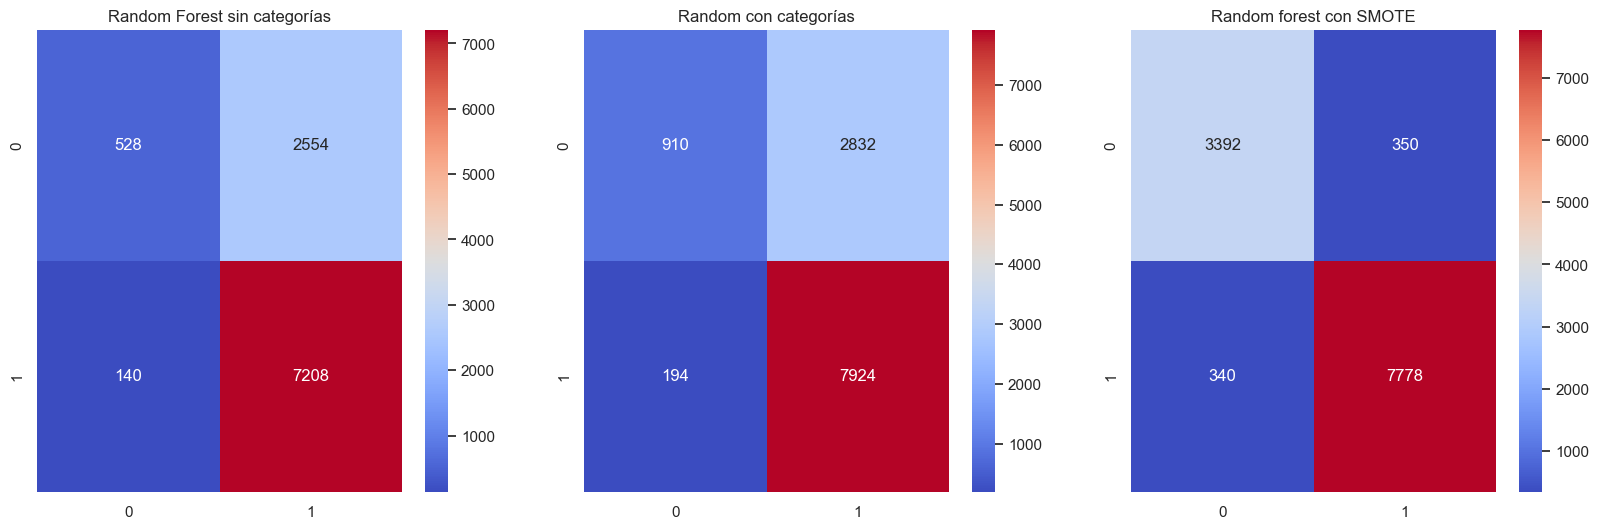

In [248]:
# GRAPHIC COMPARISON OF MODELS

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='coolwarm', fmt='d', ax=ax[0])
ax[0].set_title('Random Forest sin categorías')
sns.heatmap(confusion_matrix(y2_test, y2_pred), annot=True, cmap='coolwarm', fmt='d', ax=ax[1])
ax[1].set_title('Random con categorías')
sns.heatmap(confusion_matrix(y2_test, y_pred_rf_SMOTE), annot=True, cmap='coolwarm', fmt='d', ax=ax[2])
ax[2].set_title('Random forest con SMOTE')
plt.show()

Despues de haber corrido 3 random forest con diferentes tratamientos de variables. el que mejor resultado me proporcinó fue el Random Forest con la variable diferencia de dias categorizada y aplicandole SMOTE para corregir el desbalance de categorias de estudio.

Verdaderos positivos (TP): 7,778 casos se clasificaron correctamente como positivos (1).
Verdaderos negativos (TN): 3,392 casos se clasificaron correctamente como negativos (0).
Falsos positivos (FP): 350 casos se clasificaron incorrectamente como positivos (1), cuando en realidad eran negativos (0). Esto se conoce como error de Tipo I.
Falsos negativos (FN): 340 casos se clasificaron incorrectamente como negativos (0), cuando en realidad eran positivos (1). Esto se conoce como error de Tipo II.

### STREAMLIT

In [ ]:
import streamlit as st
import streamlit.components.v1 as components
import streamlit as st
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Tu código para cargar y preparar tus datos X2, y2 y X2_test, y2_test

# Crear una página web con Streamlit
st.title("Predicción de Reservas de Hotel")

# Añadir una sección para cargar datos
st.header("Cargar Datos")

uploaded_file = st.file_uploader("Cargar archivo CSV", type=["csv"])
if uploaded_file is not None:
    data = pd.read_csv(uploaded_file)
    st.dataframe(data)
    X = data.drop(columns=["Reserva_Realizada"])
    y = data["Reserva_Realizada"]

    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
    df_resampled_smote = pd.concat([X_resampled_smote, y_resampled_smote], axis=1)

    # Entrenar el modelo Random Forest con Grid Search y SMOTE
    param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None]
    }

    rf_SMOTE = RandomForestClassifier(random_state=42)
    grid_search_rf_SMOTE = GridSearchCV(rf_SMOTE, param_grid_rf, cv=5)
    grid_search_rf_SMOTE.fit(X_resampled_smote, y_resampled_smote)
    best_rf_SMOTE = grid_search_rf_SMOTE.best_estimator_

    # Predecir
    y_pred_rf_SMOTE = best_rf_SMOTE.predict(X2_test)

    # Calcular métricas
    accuracy_rf_SMOTE = accuracy_score(y2_test, y_pred_rf_SMOTE)
    confusion_rf_SMOTE = confusion_matrix(y2_test, y_pred_rf_SMOTE)
    report_rf_SMOTE = classification_report(y2_test, y_pred_rf_SMOTE)

    # Mostrar los resultados
    st.header("Resultados del Modelo Random Forest con SMOTE")
    st.write(f"Accuracy: {accuracy_rf_SMOTE}")
    st.write("Confusion Matrix:")
    st.dataframe(confusion_rf_SMOTE)
    st.write("Classification Report:")
    st.text(report_rf_SMOTE)